# DDPG

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

In [2]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import pickle
import gc
import json
import h5py

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline


# == recnn ==
import sys
sys.path.append("../../")
import recnn

cuda = torch.device('cuda')

# ---
frame_size = 10
batch_size = 25
n_epochs   = 100
plot_every = 30
step       = 0
# --- 

tqdm.pandas()

In [3]:
# embeddgings: https://drive.google.com/open?id=1EQ_zXBR3DKpmJR3jBgLvt-xoOvArGMsL
env = recnn.data.env.FrameEnv('../../data/embeddings/ml20_pca128.pkl',
                         '../../data/ml-20m/ratings.csv', frame_size, batch_size)

In [4]:
class Actor(nn.Module):
    def __init__(self, input_dim, action_dim, hidden_size, init_w=3e-1):
        super(Actor, self).__init__()
        
        self.drop_layer = nn.Dropout(p=0.5)
        
        self.linear1 = nn.Linear(input_dim, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, action_dim)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        # state = self.state_rep(state)
        x = F.relu(self.linear1(state))
        x = self.drop_layer(x)
        x = F.relu(self.linear2(x))
        x = self.drop_layer(x)
        # x = torch.tanh(self.linear3(x)) # in case embeds are -1 1 normalized
        x = self.linear3(x) # in case embeds are standard scaled / wiped using PCA whitening
        # return state, x
        return x

In [5]:
class Critic(nn.Module):
    def __init__(self, input_dim, action_dim, hidden_size, init_w=3e-5):
        super(Critic, self).__init__()
        
        self.drop_layer = nn.Dropout(p=0.5)
        
        self.linear1 = nn.Linear(input_dim + action_dim, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = self.drop_layer(x)
        x = F.relu(self.linear2(x))
        x = self.drop_layer(x)
        x = self.linear3(x)
        return x

In [6]:
def soft_update(net, target_net, soft_tau=1e-2):
    for target_param, param in zip(target_net.parameters(), net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )
            
def run_tests():
    test_batch = next(iter(env.test_dataloader))
    losses = ddpg_update(test_batch, params, learn=False, step=step)
    
    gen_actions = debug['next_action']
    true_actions = env.embeddings.detach().cpu().numpy()
    
    f = plotter.kde_reconstruction_error(ad, gen_actions, true_actions, cuda)
    writer.add_figure('rec_error',f, losses['step'])
    return losses

In [7]:
def ddpg_update(batch, params, learn=True, step=-1):
    
    state, action, reward, next_state, done = recnn.data.get_base_batch(batch)
        
    # --------------------------------------------------------#
    # Value Learning
    
    with torch.no_grad():
        next_action = target_policy_net(next_state)
        target_value   = target_value_net(next_state, next_action.detach())
        expected_value = reward + (1.0 - done) * params['gamma'] * target_value
        expected_value = torch.clamp(expected_value,
                                     params['min_value'], params['max_value'])

    value = value_net(state, action)
    
    value_loss = torch.pow(value - expected_value.detach(), 2).mean()
    
    if learn:
        value_optimizer.zero_grad()
        value_loss.backward()
        value_optimizer.step()
    else:
        debug['next_action'] = next_action
        writer.add_figure('next_action',
                    recnn.utils.pairwise_distances_fig(next_action[:50]), step)
        writer.add_histogram('value', value, step)
        writer.add_histogram('target_value', target_value, step)
        writer.add_histogram('expected_value', expected_value, step)
    
    # --------------------------------------------------------#
    # Policy learning
    
    gen_action = policy_net(state)
    policy_loss = -value_net(state, gen_action)
    
    if not learn:
        debug['gen_action'] = gen_action
        writer.add_histogram('policy_loss', policy_loss, step)
        writer.add_figure('next_action',
                    recnn.utils.pairwise_distances_fig(gen_action[:50]), step)
        
    policy_loss = policy_loss.mean()
    
    if learn and step % params['policy_step']== 0:
        policy_optimizer.zero_grad()
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(policy_net.parameters(), -1, 1)
        policy_optimizer.step()

        soft_update(value_net, target_value_net, soft_tau=params['soft_tau'])
        soft_update(policy_net, target_policy_net, soft_tau=params['soft_tau'])


    losses = {'value': value_loss.item(), 'policy': policy_loss.item(), 'step': step}
    recnn.utils.write_losses(writer, losses, kind='train' if learn else 'test')
    return losses

In [8]:
# === ddpg settings ===

params = {
    'gamma'      : 0.99,
    'min_value'  : -10,
    'max_value'  : 10,
    'policy_step': 10,
    'soft_tau'   : 0.001,
    
    'policy_lr'  : 1e-5,
    'value_lr'   : 1e-5,
    'actor_weight_init': 54e-2,
    'critic_weight_init': 6e-1,
}

# === end ===

In [9]:
value_net  = Critic(1290, 128, 256, params['critic_weight_init']).to(cuda)
policy_net = Actor(1290, 128, 256, params['actor_weight_init']).to(cuda)


target_value_net = Critic(1290, 128, 256).to(cuda)
target_policy_net = Actor(1290, 128, 256).to(cuda)

ad = recnn.nn.models.AnomalyDetector().to(cuda)
ad.load_state_dict(torch.load('../../models/anomaly.pt'))
ad.eval()

target_policy_net.eval()
target_value_net.eval()

soft_update(value_net, target_value_net, soft_tau=1.0)
soft_update(policy_net, target_policy_net, soft_tau=1.0)

value_criterion = nn.MSELoss()

# from good to bad: Ranger Radam Adam RMSprop
value_optimizer = recnn.optim.Ranger(value_net.parameters(),
                              lr=params['value_lr'], weight_decay=1e-2)
policy_optimizer = recnn.optim.Ranger(policy_net.parameters(),
                               lr=params['policy_lr'], weight_decay=1e-5)

loss = {
    'test': {'value': [], 'policy': [], 'step': []},
    'train': {'value': [], 'policy': [], 'step': []}
    }

debug = {}

writer = SummaryWriter(log_dir='../../runs')
plotter = recnn.utils.Plotter(loss, [['value', 'policy']],)

step 5130


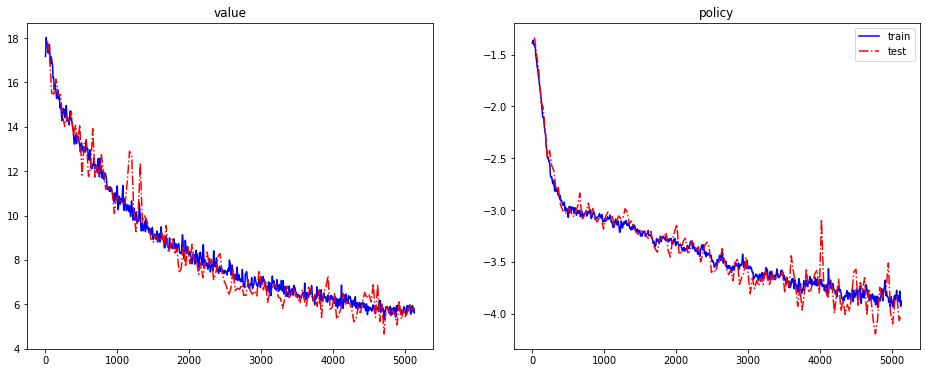

KeyboardInterrupt: 

In [18]:
for epoch in range(n_epochs):
    for batch in tqdm(env.train_dataloader):
        loss = ddpg_update(batch, params, step=step)
        plotter.log_losses(loss)
        step += 1
        if step % plot_every == 0:
            clear_output(True)
            print('step', step)
            test_loss = run_tests()
            plotter.log_losses(loss, test=True)
            plotter.plot_loss()

In [ ]:
# torch.save(value_net.state_dict(), "../../models/ddpg_value.pt")
# torch.save(policy_net.state_dict(), "../../models/ddpg_policy.pt")

# Reconstruction error

../../recnn/utils/plot.py:109: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


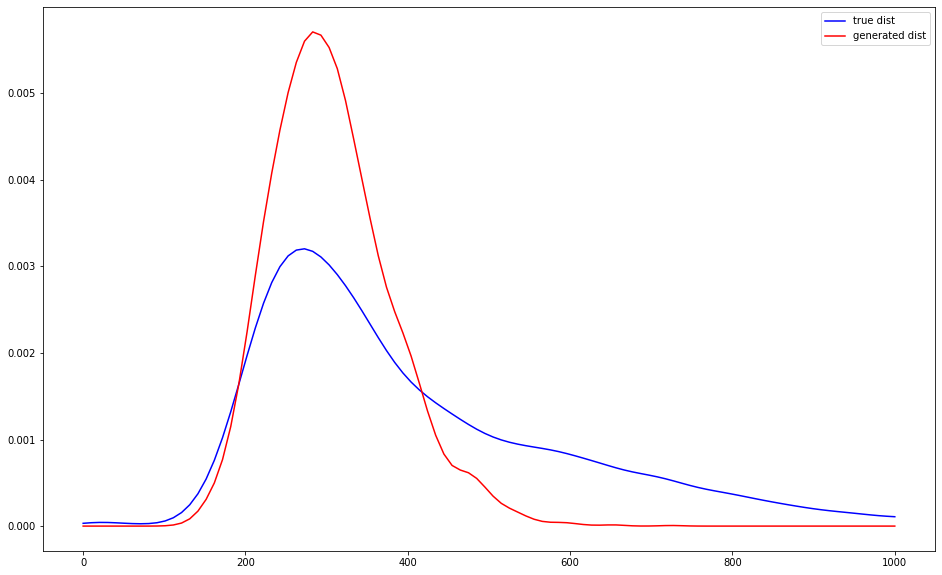

In [11]:
gen_actions = debug['next_action']
true_actions = env.embeddings.numpy()


ad = recnn.nn.AnomalyDetector().to(cuda)
ad.load_state_dict(torch.load('../../models/anomaly.pt'))
ad.eval()

plotter.plot_kde_reconstruction_error(ad, gen_actions, true_actions, cuda)